
# Analysis of Predis-MHI Data: 

##  *Notebook related to Chapter Two of the Thesis with title:

## Direct and indirect energy flexibility interactions at the Building and community scale: From system to the Human-interfaced systems


>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2FNanaKofi%2Fpredis_indirect_flexibility/master?labpath=Indirect_flex_assessment.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.

## Data specifications
>### Predis-MHI
|#|Key |Description |
|---|---|---|
| 1 | name |Predis_data_2020_2022.csv | 
| 2 | title |Predis-MHI electricity consumption and production datatsets | 
| 3 | id | |
| 4 | description |dataset containing the demand profiles <br> (building and 4 charging stations) and the solar PV (22kWp) production profiles <br>  collected from the Building Management System of GreEn-ER |
| 5 | language | en-US |
| 6 | subject |Reference the topic of the resource in ontology terms  |
| 7 | keywords |Smart Building, <br>Living Lab,<br>Building energy data] |
| 8 | publicationDate | (2023-07-17) |
| 9 | context |Used in a study to assess the impact of <br> indirect flexiblty on the perfrmance of a building's energy system  |
| 10 | spatial | France  | 
| 11 | temporal |2020-01-01 to 2022-12-31  |
| 12 | source |G2ELab |
| 13 | licenses |CC By 4.0  |
| 14 | contributors |Nana Kofi Twum-Duah, Frederic Wurtz, Stéphane Ploix, Manar Amayri |
| 15 | resources |individual file  |
| 16 | resolution |1 hour | 

## Data sources
* CO2 data obtained from electricitymaps (https://app.electricitymaps.com/map) in gCO2/kWh 
* GReEN-ER energy data (EV charging data, building energy usage, PV production) available at (https://mhi-srv.g2elab.grenoble-inp.fr/grafana/d/Xl5OAbQGk/ve-borne-de-rechargement?orgId=3&from=now-1y&to=now).

## Objectives
The goal is to evaluate the indirect flexibility potential for the Predis-MHI plaform. For this we consider the EV charging stations (particularly the plugging in and unplugging of EVs) as our indirect flexibility.

For all intents and purposes, the diagram below represents the system being evaluated.

![green-er.png](../images/green-er.png)


## Relevant imports

to run this notebook, the following libraries are required

* pandas Version => 1.2.4
* numpy Version => 1.19.5
* plotly Version => 4.14.1
* Pyomo Version ==6.0.1



### Note
This note book will not run if you do not install the dependancies, you can do that in the next cell <br>
``os.system('pip install -e .')`` in the next cell is not required if you have already done this in terminal<br>
if you need to install the dependancies, uncomment the entire code block

In [1]:
import os

work_path = os.getcwd()
# ########################################################
# #uncomment to install dependencies
# print (work_path)
# os.chdir("../")


# work_path = os.getcwd()

# print (work_path)

# os.system('pip install -e .')

# os.chdir(f"{work_path}\\notebooks")

# work_path = os.getcwd()

# print (work_path)
# ###################################################
###Necessary for glpk to  work on binder (if not on binder comment out next line)
# os.system('conda install -c conda-forge glpk')

### NOTE

The ``show_plots`` parameter is to allow for the plots to bre rendered in the GitLab repository (GitLab does not render html plots). If you want an interactive notebook set it to ``False`` and rerun the entire notebook.



Alternatively, an HTML version of this notebook is provided in the folder **html_files**

In [2]:
show_plots = True

In [3]:
import pandas as pd
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
from pyomo.environ import *
import warnings
from datetime import datetime as dt, timedelta

from tools.MPC_tools import optimizer, data_manager

### Load data

in this note book there are 2 possibilities to get the resuired data, the first is to load the predictions from the notebook ***Chapter__Comparison_of_Forecasting_Models*** or the second approach which is to load theML models and make the predictions. 

By default, the approach is to use the first method, but this can be changed by setting the ``use_csv`` parameter in the next cell to **False**




In [4]:
use_csv = True

### Digital Twin Function

The digital twin is defined such that:

$$
        P_{\text{battery}_{DT}}(t) =  \begin{cases}\min [P_{\text {battery}_{MILP}}(t), P_{{PV}_{\text {measured}}}(t)], & \text{if  }  P_{\text {battery}_{MILP}}(t)>0 \\ 
        \max [P_{\text {battery}_{MILP}}(t),-P_{\text {load}_{\text {measured}}}(t)], & \text{if  }  P_{\text {battery}_{MILP}}(t) \leq 0\end{cases}
$$ 

Where $P_{\text{battery}_{DT}}(t)$, $P_{\text {battery}_{MILP}}(t)$, $P_{{PV}_{\text {measured}}}(t)$ and $P_{\text {load}_{\text {measured}}}(t)$ are the battery power from the digital twin, the battery power computed by the MILP, the measured solar PV power, and the measured demand of the building for timestep $t$ respectively. Additionally, to ensure the lower and upper state of charge limits were respected: 



$$
 P_{\text {battery} _{DT}}(t)= \begin{cases}E_{\text {battery} _{\max }}-E_{\text {battery }_{DT}}(t-1), & E_{\text {battery}_{DT}}(t)>E_{\text {battery}_{\max }} \\ E_{\text {battery}_{\min}}-E_{\text {battery}_{DT}}(t-1), & E_{\text {battery}_{DT}}(t) \leq E_{\text {battery}_{\min }}\end{cases}
$$ 

Where $E_{\text {battery}_{\min}}$ and $E_{\text {battery}_{\max}}$ are the minimum and maximum allowed energy in the battery (i.e. the minimum and maximum SOCs respectively and $E_{\text {battery }_{DT}}(t)$ is the energy in the battery at step $t$. 

In [5]:

def digital_twin(prod , demand, battery, bat_energy, c_eff, d_eff):
    
    energy = [bat_energy]
    new_bat = []
    
    for p,d,b in zip(prod , demand, battery):
        
        if b > 0:
            b = min(b,p)
            
            if energy[-1] + (c_eff * b ) <= 50:
                pass
                
            else:
                print("ERROR MAX SOC EXCEEDED")
                b = (50 - energy[-1])/c_eff
            
            energy.append(energy[-1] + (c_eff * b ))
            
            
            
        else:
            b = min(abs(b) , d)
            
            b *= -1
            
            if energy[-1] + (c_eff * b ) >= 10.5:
                pass
                
                
            else:
                print("ERROR MAX SOC EXCEEDED")
                
                b = (10.5 - energy[-1] ) * d_eff
            
            energy.append(energy[-1] + (b / d_eff))
        new_bat.append(b)
#     print (f"success : {new_bat}")
   
    end_cap = energy[-1]
        
    return end_cap,new_bat, energy[:-1]
        
        
            

 ### Practical Implementation
Having developed both the forecasting and optimization components of the Machine Learning-based Model Predictive Control (ML-MPC), the approach was implemented using the battery of the Predis-MHI building. However, because the battery was installed off-site, and there is no existing contract that permits the export of energy from the off-site building onto the grid, the tests carried out only permitted a maximum discharge of 1kW (results below). The Measurements show that the BMS of the battery generally respected the control signals and allowed for the design of a Digital Twin of the battery to be implemented. 


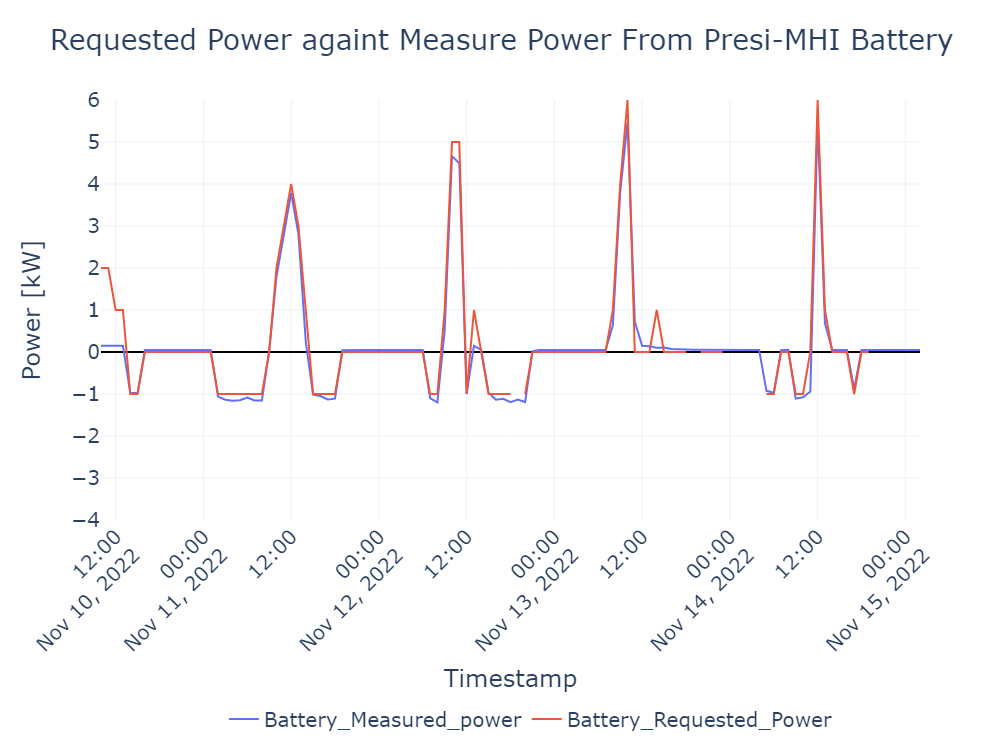

In [6]:
df_eaton = pd.read_csv("../data/eaton/Eaton Battery Power.csv", sep = ";",
                 index_col = "Timestamp", parse_dates = True, decimal ="." )
df_eaton  = df_eaton.resample("1H").mean()

layout = {
    "width" : 1200 , "height" : 750,
   "font":{"size" : 20}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',"title_text":"Power [kW]",
              "range": [-4, 6], "dtick": 1},
    "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.52,"x":0.150, "title" : ""}
            }

fig = px.line(df_eaton,template ="plotly_white", title = "Requested Power againt Measure Power From Presi-MHI Battery"  ) 
fig.update_layout(layout)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Get predicted data



for this application we consider the predictions from the following ML models

* demand forecasting : XGBOOST
* PV forecasting  : LGBM
* EV deman forecasting : LGBM



In [7]:
if use_csv:
    df = pd.read_csv("../data/demand_prediction.csv", parse_dates = True, index_col = "Time")
    df =  df[["XGBOOST","Measured",'Naive']]

    df.rename(columns = {"XGBOOST":"Consumption[predicted]","Measured":"Consumption[measured]","Naive":"Consumption[Naive]"},inplace = True)


    temp = pd.read_csv("../data/production_prediction.csv", parse_dates = True, index_col = "Time")
    temp =  temp[["LGBM","Measured","Naive"]]

    temp.rename(columns = {"LGBM":"Production[predicted]","Measured":"Production[measured]","Naive":"Production[Naive]"},inplace = True)

    df = pd.concat([df,temp],axis = 1)



    temp = pd.read_csv("../data/ev_prediction.csv", parse_dates = True, index_col = "Time")
    temp =  temp[["LGBM","Measured","Naive"]]

    temp.rename(columns = {"LGBM":"chargers[predicted]","Measured":"chargers[measured]","Naive":"chargers[Naive]"},inplace = True)


    df = pd.concat([df,temp],axis = 1)


    temp = pd.read_csv("../data/predis_mhi_2015.csv",
                     sep = ",", decimal = ".",parse_dates = True , index_col = 'Datetime')
    temp.fillna(0, inplace = True)

    temp  = temp[[f"charger {x}" for x in range (1,5)]]
    temp["total_chargers"] = temp.sum(axis=1)
    df = pd.concat([df,temp],axis = 1)




    # df["chargers[measured]"] = [0] * len(df)
    # df["chargers[predicted]"] = [0] * len(df)

    df["Production[predicted]"][df["Production[predicted]"] < 0] = 0
    df["Consumption[predicted]"][df["Consumption[predicted]"] < 0] = 0


    df.loc[df['Production[predicted]'] < 0.1, 'Production[predicted]'] = 0
    df.loc[df['Consumption[predicted]'] < 0.1, 'Consumption[predicted]'] = 0
    df.loc[df['chargers[predicted]'] < 3, 'chargers[predicted]'] = 0
    df.loc[df['chargers[measured]'] < 3, 'chargers[measured]'] = 0

    df = df[df.index <'2022-11-19 00:00:00']
    df = df[df.index >='2022-01-01 00:00:00']
    df.fillna(0,inplace = True)
    df
    
else : 
    #todo add ML models
    
    df = pd.read_csv("../data/predis_mhi_2015.csv",
                     sep = ",", decimal = ".",parse_dates = True , index_col = 'Datetime')
    
    
    
    df = df[df.index <'2022-11-19 00:00:00']
    df = df[df.index >='2022-01-01 00:00:00']
    
    df.rename(columns = {"Consumption" : "Consumption[measured]" , 
                        "production" : "Production[measured]"})
    
    temp = df [[f"charger {x}" for x in range (1,5)]]
    temp["total_chargers"] = temp.sum(axis=1)
    
    temp = df [[f"charger {x}" for x in range (1,5)]]
    temp["chargers[measured]"] = temp.sum(axis=1)
    df = pd.concat([df,temp],axis = 1)
    
    
    temp = temp.resample("1D").sum()

    temp = temp.resample("1H").sum()
    
    df["chargers[measured]"] = temp["chargers[measured]"]
    
    
    
    
    
    
    
#     df = pd.read_csv("../data/demand_prediction.csv", parse_dates = True, index_col = "Time")
#     df =  df[["XGBOOST","Measured",'Naive']]

#     df.rename(columns = {"XGBOOST":"Consumption[predicted]","Measured":"Consumption[measured]","Naive":"Consumption[Naive]"},inplace = True)


#     temp = pd.read_csv("../data/production_prediction.csv", parse_dates = True, index_col = "Time")
#     temp =  temp[["LGBM","Measured","Naive"]]

#     temp.rename(columns = {"LGBM":"Production[predicted]","Measured":"Production[measured]","Naive":"Production[Naive]"},inplace = True)

#     df = pd.concat([df,temp],axis = 1)



#     temp = pd.read_csv("../data/ev_prediction.csv", parse_dates = True, index_col = "Time")
#     temp =  temp[["LGBM","Measured","Naive"]]

#     temp.rename(columns = {"LGBM":"chargers[predicted]","Measured":"chargers[measured]","Naive":"chargers[Naive]"},inplace = True)


#     df = pd.concat([df,temp],axis = 1)


#     temp = pd.read_csv("../data/predis_mhi_2015.csv",
#                      sep = ",", decimal = ".",parse_dates = True , index_col = 'Datetime')
#     temp.fillna(0, inplace = True)

#     temp  = temp[[f"charger {x}" for x in range (1,5)]]
#     temp["total_chargers"] = temp.sum(axis=1)
#     df = pd.concat([df,temp],axis = 1)




#     # df["chargers[measured]"] = [0] * len(df)
#     # df["chargers[predicted]"] = [0] * len(df)

#     df["Production[predicted]"][df["Production[predicted]"] < 0] = 0
#     df["Consumption[predicted]"][df["Consumption[predicted]"] < 0] = 0


#     df.loc[df['Production[predicted]'] < 0.1, 'Production[predicted]'] = 0
#     df.loc[df['Consumption[predicted]'] < 0.1, 'Consumption[predicted]'] = 0
#     df.loc[df['chargers[predicted]'] < 3, 'chargers[predicted]'] = 0
#     df.loc[df['chargers[measured]'] < 3, 'chargers[measured]'] = 0

#     df = df[df.index <'2022-11-19 00:00:00']
#     df = df[df.index >='2022-01-01 00:00:00']
#     df.fillna(0,inplace = True)
#     df
    

## scenarios considered
1. **Perfect Predictor Scenario**: For this scenario, we assumed that the solar PV, demand, and EV Charger demand profiles for the next day were perfectly predicted. Hence the results from this scenario could be considered the global optimal.

2. **ML-MPC Scenario**: this scenario considered the ML predictors discussed in this chapter for the prediction of the solar PV, demand, and EV Charger demand profiles for the next day. Thus, the optimal solution here integrates the prediction errors. 

3. **ML-MPC and Digital Twin Scenario**: in this scenario, the battery charge/discharge schedule computed by the MILP in the ML-MPC scenario is used as control signals for the digital twin of the battery. Thus, this scenario allows us to assess the performance of the ML-MPC. 

### Perfect Predictor Scenario

In [8]:
## Perfect##########
df["battery[measured]"] = [0] * len(df)

opt = optimizer.Optimize(pv = "Production[measured]", demand = "Consumption[measured]", indirect_flex = ["chargers[measured]"])
init_cap = 50
df
for day in df.resample("1D").sum().index:
#     opt = Optimize(pv = "Production[measured]", demand = "Consumption[measured]", indirect_flex = ["chargers[measured]"])
    
    temp = df.copy().loc[str(day.date())]
    print("optimizing  ", (day.date()))

    m, temp = opt.simulate_(df = temp ,  init_cap = init_cap,solver ="gurobi")
    init_cap = m.end_cap.value
#     if str(day.date())=="2022-02-02"
    print(m.end_cap.value)
    df.loc[str(day.date()), "battery[measured]"] = temp["battery_power"].tolist()
#     break
# temp

optimizing   2022-01-01
44.73636000221523
optimizing   2022-01-02
44.73646421187893
optimizing   2022-01-03
11.000000000000002
optimizing   2022-01-04
10.999999999999998
optimizing   2022-01-05
11.000000000000002
optimizing   2022-01-06
11.000000000000002
optimizing   2022-01-07
11.000000000000002
optimizing   2022-01-08
10.999999999999995
optimizing   2022-01-09
11.0
optimizing   2022-01-10
11.0
optimizing   2022-01-11
11.000000000000002
optimizing   2022-01-12
11.000000000000002
optimizing   2022-01-13
10.999999999999998
optimizing   2022-01-14
11.0
optimizing   2022-01-15
26.817991726314624
optimizing   2022-01-16
21.94109236905679
optimizing   2022-01-17
11.000000000000002
optimizing   2022-01-18
11.000000000000002
optimizing   2022-01-19
11.000000000000004
optimizing   2022-01-20
11.0
optimizing   2022-01-21
11.000000000000004
optimizing   2022-01-22
29.770593676429176
optimizing   2022-01-23
28.69362568887737
optimizing   2022-01-24
11.000000000000002
optimizing   2022-01-25
11.0

44.73664842135052
optimizing   2022-07-18
44.73660157943893
optimizing   2022-07-19
35.31707453672407
optimizing   2022-07-20
42.17419074219343
optimizing   2022-07-21
41.57876210555367
optimizing   2022-07-22
11.000000000000004
optimizing   2022-07-23
44.736649473979995
optimizing   2022-07-24
42.63139052660736
optimizing   2022-07-25
14.364927984606792
optimizing   2022-07-26
42.63134157943578
optimizing   2022-07-27
43.683970000492614
optimizing   2022-07-28
39.47340842177631
optimizing   2022-07-29
41.24629358177968
optimizing   2022-07-30
42.63138842134526
optimizing   2022-07-31
41.57876210555265
optimizing   2022-08-01
42.63139052660841
optimizing   2022-08-02
43.68396894786314
optimizing   2022-08-03
42.63138842134735
optimizing   2022-08-04
43.68401894766314
optimizing   2022-08-05
40.52603579019946
optimizing   2022-08-06
44.73664736871894
optimizing   2022-08-07
42.631392631868415
optimizing   2022-08-08
43.6839710531242
optimizing   2022-08-09
41.57871210575158
optimizing  

### ML-MPC Scenario

In [9]:
## Predicted##########
df["battery[predicted]"] = [0] * len(df)


opt = optimizer.Optimize(pv = "Production[predicted]", demand = "Consumption[predicted]", indirect_flex = ["chargers[predicted]"])
init_cap = 50
for day in df.resample("1D").sum().index:
    temp = df.copy().loc[str(day.date())]
    print("optimizing  ", (day.date()))
    
    m, temp = opt.simulate_(df = temp ,  init_cap = init_cap,solver ="gurobi")
    init_cap = m.end_cap.value
#     print(m.end_cap.value)
    df.loc[str(day.date()), "battery[predicted]"] = temp["battery_power"].tolist()

optimizing   2022-01-01
optimizing   2022-01-02
optimizing   2022-01-03
optimizing   2022-01-04
optimizing   2022-01-05
optimizing   2022-01-06
optimizing   2022-01-07
optimizing   2022-01-08
optimizing   2022-01-09
optimizing   2022-01-10
optimizing   2022-01-11
optimizing   2022-01-12
optimizing   2022-01-13
optimizing   2022-01-14
optimizing   2022-01-15
optimizing   2022-01-16
optimizing   2022-01-17
optimizing   2022-01-18
optimizing   2022-01-19
optimizing   2022-01-20
optimizing   2022-01-21
optimizing   2022-01-22
optimizing   2022-01-23
optimizing   2022-01-24
optimizing   2022-01-25
optimizing   2022-01-26
optimizing   2022-01-27
optimizing   2022-01-28
optimizing   2022-01-29
optimizing   2022-01-30
optimizing   2022-01-31
optimizing   2022-02-01
optimizing   2022-02-02
optimizing   2022-02-03
optimizing   2022-02-04
optimizing   2022-02-05
optimizing   2022-02-06
optimizing   2022-02-07
optimizing   2022-02-08
optimizing   2022-02-09
optimizing   2022-02-10
optimizing   202

### ML-MPC (Naive predictors)

In [10]:
df["battery[Naive]"] = [0] * len(df)


opt = optimizer.Optimize(pv = "Production[Naive]", demand = "Consumption[Naive]", indirect_flex = ["chargers[Naive]"])
init_cap = 50
for day in df.resample("1D").sum().index:
    temp = df.copy().loc[str(day.date())]
    print("optimizing  ", (day.date()))
    
    m, temp = opt.simulate_(df = temp ,  init_cap = init_cap,solver ="gurobi")
    init_cap = m.end_cap.value
#     print(m.end_cap.value)
    df.loc[str(day.date()), "battery[Naive]"] = temp["battery_power"].tolist()

optimizing   2022-01-01
optimizing   2022-01-02
optimizing   2022-01-03
optimizing   2022-01-04
optimizing   2022-01-05
optimizing   2022-01-06
optimizing   2022-01-07
optimizing   2022-01-08
optimizing   2022-01-09
optimizing   2022-01-10
optimizing   2022-01-11
optimizing   2022-01-12
optimizing   2022-01-13
optimizing   2022-01-14
optimizing   2022-01-15
optimizing   2022-01-16
optimizing   2022-01-17
optimizing   2022-01-18
optimizing   2022-01-19
optimizing   2022-01-20
optimizing   2022-01-21
optimizing   2022-01-22
optimizing   2022-01-23
optimizing   2022-01-24
optimizing   2022-01-25
optimizing   2022-01-26
optimizing   2022-01-27
optimizing   2022-01-28
optimizing   2022-01-29
optimizing   2022-01-30
optimizing   2022-01-31
optimizing   2022-02-01
optimizing   2022-02-02
optimizing   2022-02-03
optimizing   2022-02-04
optimizing   2022-02-05
optimizing   2022-02-06
optimizing   2022-02-07
optimizing   2022-02-08
optimizing   2022-02-09
optimizing   2022-02-10
optimizing   202

### ML-MPC and Digital Twin Scenario

In [11]:
#############digital twin#################

df["battery[Digital_Twin]"] = [0] * len(df)
df["battery[DT_MILP]"] = [0] * len(df)

df["en[Digital_Twin]"] = [0]* len(df)
opt = optimizer.Optimize(pv = "Production[predicted]", demand = "Consumption[predicted]", indirect_flex = ["chargers[predicted]"])
init_cap = 50

for day in df.resample("1D").sum().index:
    temp_ = df.copy().loc[str(day.date())]
    print("optimizing  ", (day.date()))
    
    m, temp = opt.simulate_(df = temp_ ,  init_cap = init_cap)
    print (init_cap)
    
    df.loc[str(day.date()), "battery[DT_MILP]"] = temp["battery_power"].tolist()
    
    
    temp_["demand"] = temp_[["Consumption[measured]","total_chargers"]].sum(axis=1)
    init_cap,new_bat,en = digital_twin(prod = temp_["Production[measured]"].tolist() ,
                                   demand = temp_["demand"].tolist(),
                                   battery = temp["battery_power"],
                                    bat_energy= init_cap,
                                    c_eff = 0.98,
                                    d_eff = 0.95)
    print (init_cap)
    
    df.loc[str(day.date()), "battery[Digital_Twin]"] = new_bat
    df.loc[str(day.date()), "en[Digital_Twin]"] = en

optimizing   2022-01-01
50
ERROR MAX SOC EXCEEDED
45.68774178947367
optimizing   2022-01-02
45.68774178947367
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.20083718460295
optimizing   2022-01-03
45.20083718460295
18.196127585607652
optimizing   2022-01-04
18.196127585607652
11.672734550160653
optimizing   2022-01-05
11.672734550160653
11.00026467577033
optimizing   2022-01-06
11.00026467577033
11.000264003300423
optimizing   2022-01-07
11.000264003300423
11.000264003299712
optimizing   2022-01-08
11.000264003299712
11.000264003299712
optimizing   2022-01-09
11.000264003299712
11.000264003299712
optimizing   2022-01-10
11.000264003299712
11.000264003299712
optimizing   2022-01-11
11.000264003299712
11.000264003299712
optimizing   2022-01-12
11.000264003299712
11.000264003299712
optimizing   2022-01-13
11.000264003299712
11.000264003299712
optimizing   2022-01-14
11.000264003299712
11.00026400329967
optimizing   2022-01-15
11.00026400329967
ERROR MAX SOC EXCEEDE

44.68814449871865
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
43.237066378509354
optimizing   2022-04-19
43.237066378509354
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
43.73876812310213
optimizing   2022-04-20
43.73876812310213
40.53671365919105
optimizing   2022-04-21
40.53671365919105
37.11623445317381
optimizing   2022-04-22
37.11623445317381
13.030812225258702
optimizing   2022-04-23
13.030812225258702
36.95942083246697
optimizing   2022-04-24
36.95942083246697
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
43.97201849728764
optimizing   2022-04-25
43.97201849728764
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
44.52242117885268
optimizing   2022-04-26
44.52242117885268
41.29955467707485
optimizing   2022-04-27
41.29955467707485
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
44.432868641227955
optimizing   2022-04-28
44.432868641227955
ERROR MAX SOC EXCEEDED
ERROR MA

46.38988371891992
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
46.09320685409797
optimizing   2022-06-24
46.09320685409797
37.84303167007836
optimizing   2022-06-25
37.84303167007836
43.92700019749885
optimizing   2022-06-26
43.92700019749885
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
46.206024964155375
optimizing   2022-06-27
46.206024964155375
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
46.23856744582665
optimizing   2022-06-28
46.23856744582665
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
46.24549928009339
optimizing   2022-06-29
46.24549928009339
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.55975471366242
optimizing   2022-06-30
45.55975471366242
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MA

44.98944927089653
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
44.590008954477156
optimizing   2022-08-26
44.590008954477156
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
46.39749345633765
optimizing   2022-08-27
46.39749345633765
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.29754292025318
optimizing   2022-08-28
45.29754292025318
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.66342999057548
optimizing   2022-08-29
45.66342999057548
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.77230463084227
optimizing   2022-08-30
45.77230463084227
ERROR MAX SOC EXCEEDED
36.95808553601307
optimizing   2022-08-31
36.95808553601307
37.964283981375594
optimizing   2022-09-01
37.964283981375594
43.311047414390686
optimizing   2022-09-02
43.311047414390686
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
ERROR MAX SOC EXCEEDED
45.4900279551

### Visualizations

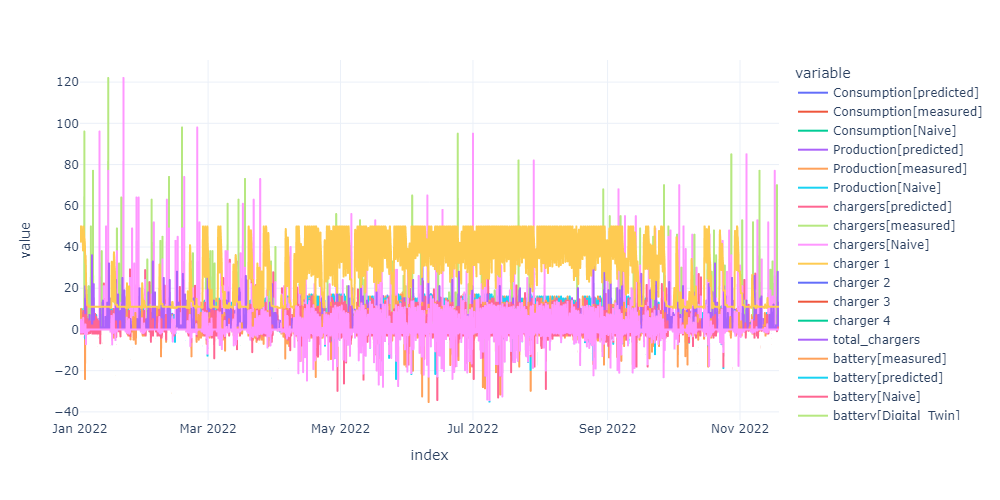

In [12]:
fig = px.line(df, template = 'plotly_white')

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

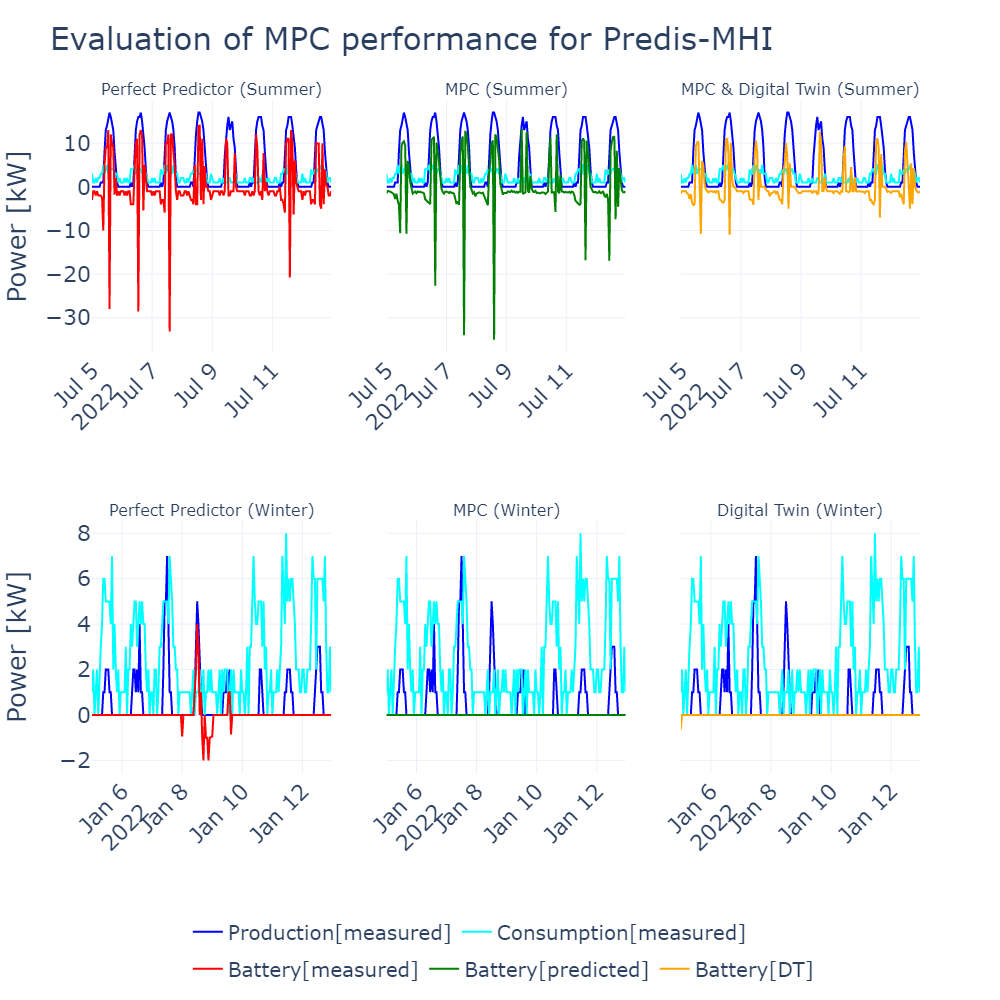

In [13]:
# df_plot = df.copy()
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px

layout = {
    "title_text"  : 'Evaluation of MPC performance for Predis-MHI ',
   "font":{"size" : 22}, "template": "plotly_white", "width" : 1500, "height" : 1000,
    'xaxis': {"title_text" : "","tickangle" : -45},
    'xaxis2': { "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    'xaxis5': { "title_text" : "","tickangle" : -45},
    'xaxis6': { "title_text" : "","tickangle" : -45},
    'xaxis7': { "title_text" : "","tickangle" : -45},
    'xaxis8': { "title_text" : "","tickangle" : -45},
    "yaxis": {"title_text" : 'Power [kW]'},
    "yaxis4": {"title_text" : 'Power [kW]'},
     "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.32,"x":0.150, "title" : ""}
            }




df_ = df.copy().loc["2022-07-05": "2022-07-12"]
# Create subplots with 1 row and 3 columns, sharing the y-axis
fig = sp.make_subplots(rows=2, cols=3, subplot_titles=('Perfect Predictor (Summer)', 'MPC (Summer)', 'MPC & Digital Twin (Summer)',
                                                       'Perfect Predictor (Winter)', 'MPC (Winter)', 'Digital Twin (Winter)'),
                       shared_yaxes=True)

# Add the measured column to each subplot
row = 1
col = ["blue", 'cyan']
fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=True,
                         line_color= col[0]), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=True,
                         line_color= col[1]), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=False,
                         line_color=col[0]), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=False,
                         line_color= col[1]), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=False,
                         line_color=col[0]), row=row, col=3)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=False,
                         line_color= col[1]), row=row, col=3)


# Add the remaining columns to each subplot
show = True
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[measured]'], name='Battery[measured]',showlegend = show,
                         legendgroup= "battery[measured]" , line_color='red'), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='Battery[predicted]',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='green'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Battery[DT]',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='orange'), row=row, col=3)
# fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta',showlegend=True,), row=1, col=4)

df_ = df.copy().loc["2022-01-05": "2022-01-12"]
row = 2


fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=False,
                         line_color= col[0]), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=False,
                         line_color= col[1]), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=False,
                         line_color=col[0]), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=False,
                         line_color= col[1]), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Production[measured]'], name='Production[measured]', legendgroup='Production[measured]', showlegend=False,
                         line_color=col[0]), row=row, col=3)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Consumption[measured]'], name='Consumption[measured]', legendgroup='Consumption[measured]', showlegend=False,
                         line_color= col[1]), row=row, col=3)


show=False
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[measured]'], name='Battery_Power[measured]',showlegend = show,
                         legendgroup= "battery[measured]" , line_color='red'), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='Battery_Power[predicted]',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='green'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Battery_Power[DT]',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='orange'), row=row, col=3)
fig.update_layout(layout)


# fig.update_xaxes(matches='x')
# fig.update_yaxes(matches='y')

fig.update_layout(legend=dict(orientation="h"))

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()
# Show the plot
# fig.show()






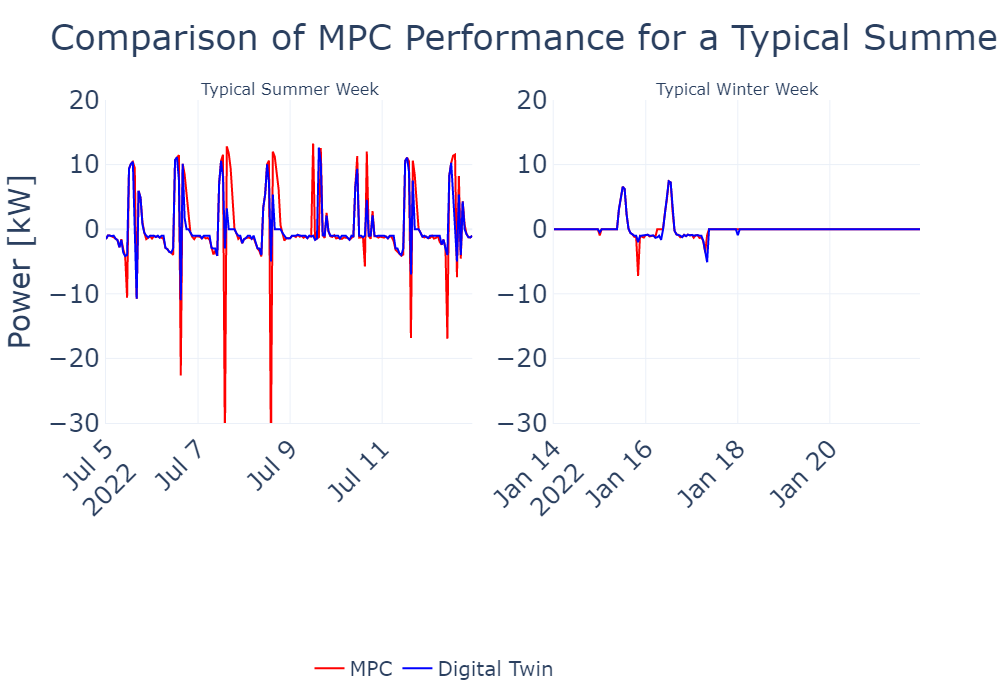

In [14]:
# df_plot = df.copy()
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px

layout = {
    "title_text"  : 'Comparison of MPC Performance for a Typical Summer and Winter Day ',
   "font":{"size" : 25}, "template": "plotly_white", "width" : 1500, "height" : 700,
    'xaxis': {"showline": True,"title_text" : "","tickangle" : -45},
    'xaxis2': {"showline": True, "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    'xaxis5': { "title_text" : "","tickangle" : -45},
    'xaxis6': { "title_text" : "","tickangle" : -45},
    'xaxis7': { "title_text" : "","tickangle" : -45},
    'xaxis8': { "title_text" : "","tickangle" : -45},
    "yaxis": {"showline": True,"title_text" : 'Power [kW]' ,"range": [-30, 20], "dtick": 10},
    "yaxis2": {"showline": True,"title_text" : '', "range": [-30, 20], "dtick": 10},
    
    
     "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.82,"x":0.250, "title" : ""}
            }




df_ = df.copy().loc["2022-07-05": "2022-07-12"]

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Typical Summer Week', 'Typical Winter Week'),
                       shared_yaxes=False)

# Add the measured column to each subplot
row = 1
col = ["blue", 'cyan']


show = True

fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=1)
# fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta',showlegend=True,), row=1, col=4)

df_ = df.copy().loc["2022-01-14": "2022-01-21"]
# df_ = df.copy().loc["2022-01-02"]
row = 1



show=False
# fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[measured]'], name='Perfect Predictor',showlegend = show,
#                          legendgroup= "battery[measured]" , line_color='green'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=2)
fig.update_layout(layout)


fig.update_layout(legend=dict(orientation="h"))
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()





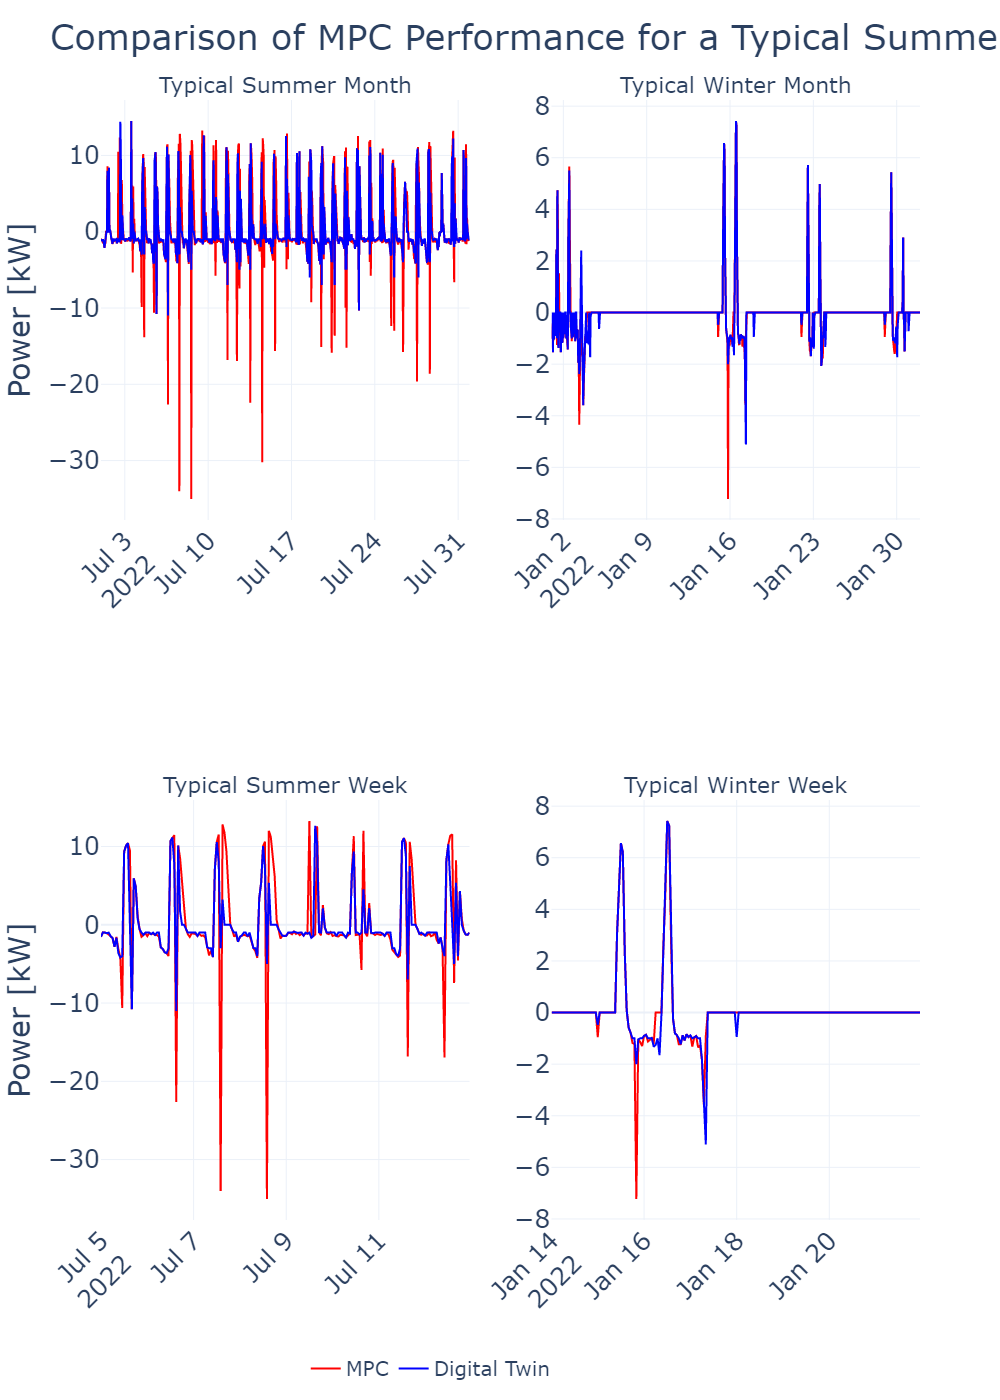

In [15]:
# df_plot = df.copy()
import plotly.subplots as sp
import plotly.graph_objects as go
import plotly.express as px

layout = {
    "title_text"  : 'Comparison of MPC Performance for a Typical Summer and Winter Day ',
   "font":{"size" : 25}, "template": "plotly_white", "width" : 1400, "height" : 1400,
    'xaxis': {"title_text" : "","tickangle" : -45},
    'xaxis2': { "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    "yaxis": {"title_text" : 'Power [kW]' },
    "yaxis3": {"title_text" : 'Power [kW]'},
    
#     "yaxis3": {"showline": True,"linecolor": "black", "linewidth": 2, 'zerolinecolor':'black',
#               "side": 'left', "title_text" : "" ,"range": [-30, 20], "dtick": 10},
#     "yaxis4": {"showline": True,"linecolor": "black", "linewidth": 2,  'zerolinecolor':'black',
#                "side": 'left', "title_text" : "", "overlaying": 'y' ,"range": [-30, 20], "dtick": 10},
    
     "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.15,"x":0.250, "title" : ""}
            }



fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('Typical Summer Month', 'Typical Winter Month',
                                                       'Typical Summer Week', 'Typical Winter Week'),
                       shared_yaxes=False)

df_ = df.copy().loc["2022-07-05": "2022-07-12"]
df_ = df.copy().loc["2022-07-01": "2022-07-31"]

row = 1

# Add the remaining columns to each subplot
show = True

fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=1)
# fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta',showlegend=True,), row=1, col=4)

df_ = df.copy().loc["2022-01-14": "2022-01-21"]
df_ = df.copy().loc["2022-01-01": "2022-01-31"]


show=False

fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=2)


df_ = df.copy().loc["2022-07-05": "2022-07-12"]


row = 2

show = False

fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=1)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=1)
# fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta',showlegend=True,), row=1, col=4)

df_ = df.copy().loc["2022-01-14": "2022-01-21"]

show=False

fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[predicted]'], name='MPC',showlegend = show,
                         legendgroup= "battery[predicted]" ,  line_color='red'), row=row, col=2)
fig.add_trace(go.Scatter(x=df_.index, y=df_['battery[Digital_Twin]'], name='Digital Twin',showlegend = show,
                         legendgroup= "battery[Digital_Twin]" ,line_color='Blue'), row=row, col=2)


fig.update_layout(layout)


show=True


fig.update_layout(legend=dict(orientation="h"))
fig.update_annotations(font_size=22)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()




### Comment 
Given the scenarios descrided in the presceding sections, the results shown above were obtained. The battery power from the digital twin (blue curve) is seen to charge and discharge lower amounts of energy relative to the perfect predictor and he ML-MPC scenarios. This behavior is due to the reactive nature of the battery's BMS which, to an extent reduces the errors associated with the forecasts of the ML-MPC.

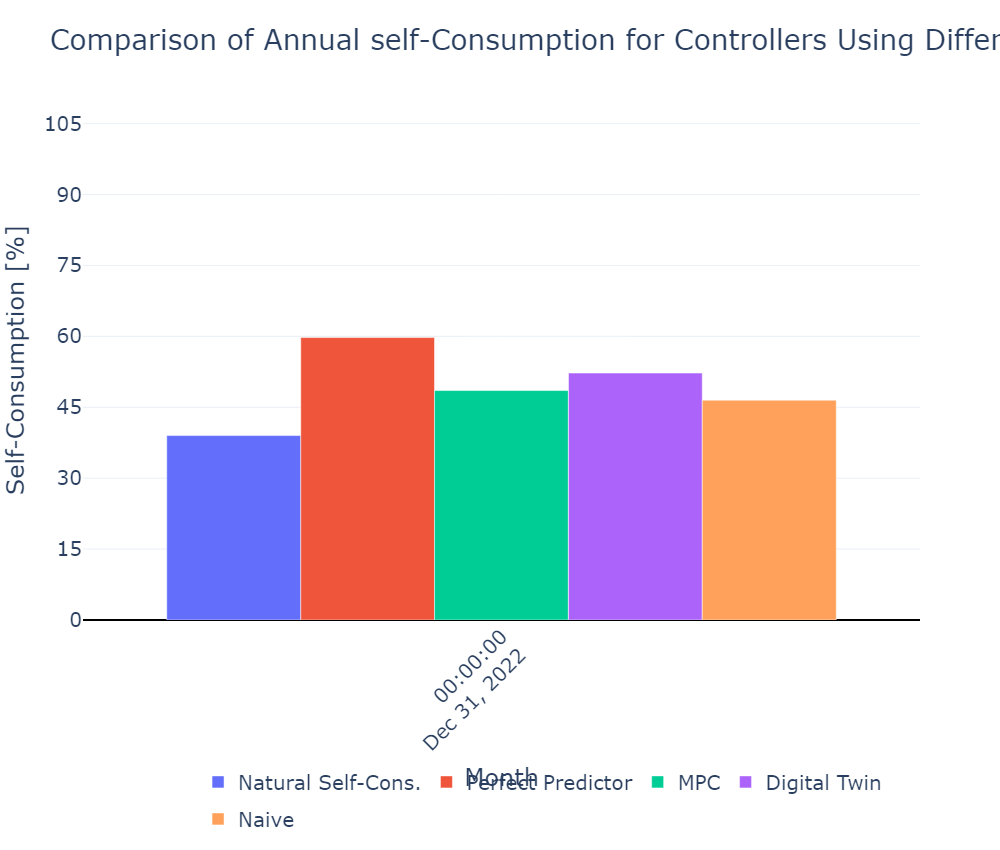

Self_Consumption[Natural]  Self_Consumption[measured]  \
2022-12-31                  39.012432                   59.746613   

            Self_Consumption[predicted]  Self_Consumption[Digital_Twin]  \
2022-12-31                    48.539929                       52.237743   

            Self_Consumption[Naive]  
2022-12-31                46.497468

In [16]:
import numpy as np
layout = {
    "width" : 1500 , "height" : 850,
   "font":{"size" : 20}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45,"title_text": "Month"},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',"title_text":"Self-Consumption [%]",
              "range": [0, 110], "dtick": 15},
    "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.42,"x":0.150, "title" : ""}
            }

df_plot = df.copy()
df_plot['Production[Digital_Twin]'] = df_plot['Production[predicted]']
df_plot['Consumption[Digital_Twin]'] = df_plot['Production[predicted]']

scenarios = ["Natural","measured", "predicted","Digital_Twin", "Naive"]
for scenario in scenarios:
    
    if "Nat" in scenario:
        df_plot[f"sc[{scenario}]"] = np.minimum(df_plot[f"Production[measured]"], df_plot[f"Consumption[measured]"])
    else:
        df_plot[f"sc[{scenario}]"] =  np.minimum(df_plot[f"Production[measured]"]- df_plot[f"battery[{scenario}]"] , 
                                                         df_plot[f"Consumption[measured]"])
    
df_plot = df_plot.resample("1Y", label = "right").sum()
# df_plot.index = ['January', "February", "March", "April", "May" , "June", "July", "August", "September","October", "November"]
plots = []
for scenario in scenarios:
    plots.append(f"Self_Consumption[{scenario}]")
    df_plot[f"Self_Consumption[{scenario}]"] =  (df_plot[f"sc[{scenario}]"] / df_plot[f"Production[measured]"]) *100


    
fig = px.bar(df_plot[plots], barmode = "group", 
             title ="Comparison of Annual self-Consumption for Controllers Using Different Predictors" )
fig.update_layout(layout)
fig.data[0].name = "Natural Self-Cons." 
fig.data[1].name = "Perfect Predictor"
fig.data[2].name = "MPC"
fig.data[3].name = "Digital Twin"
fig.data[4].name = "Naive"


if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

df_plot[plots]
       

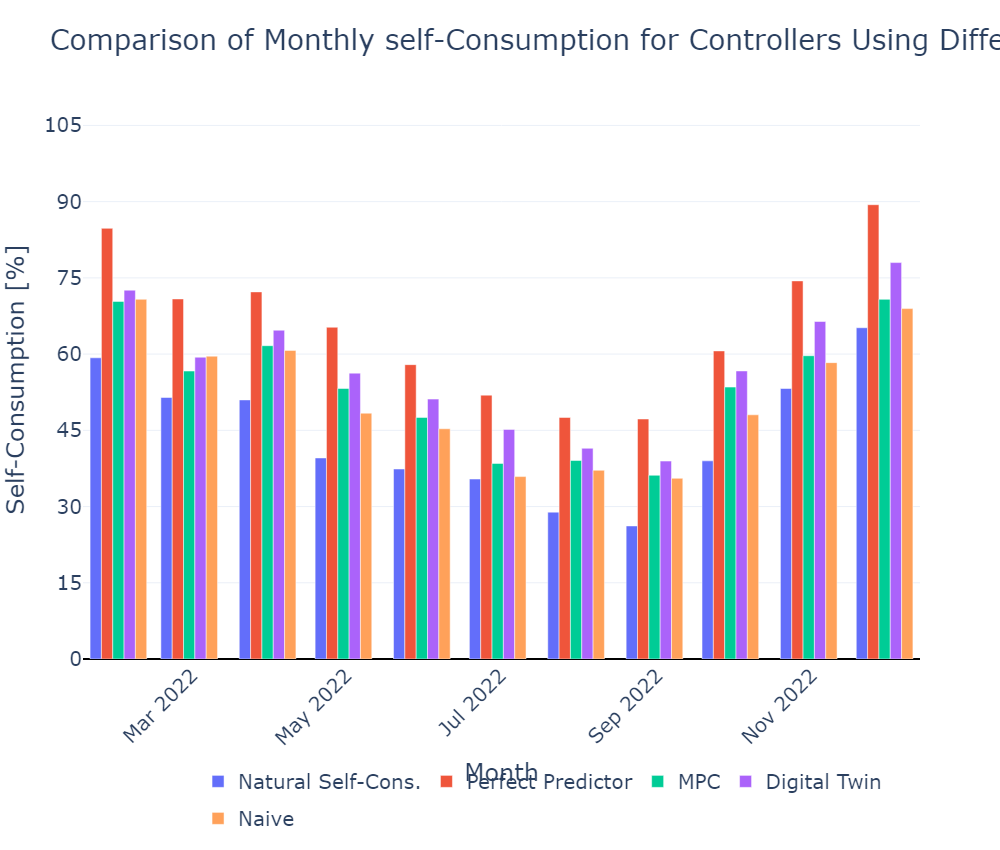

Self_Consumption[Natural]  Self_Consumption[measured]  \
2022-01-31                  59.267241                   84.746022   
2022-02-28                  51.460142                   70.852798   
2022-03-31                  50.984157                   72.239141   
2022-04-30                  39.563989                   65.282479   
2022-05-31                  37.386325                   57.922775   
2022-06-30                  35.408300                   51.922929   
2022-07-31                  28.901067                   47.531737   
2022-08-31                  26.183844                   47.225481   
2022-09-30                  38.992537                   60.624125   
2022-10-31                  53.226976                   74.402193   
2022-11-30                  65.185185                   89.395159   

            Self_Consumption[predicted]  Self_Consumption[Digital_Twin]  \
2022-01-31                    70.366945                       72.578053   
2022-02-28                    56.660315                       59.386254   
2022-03-31                    61.653315                       64.702024   
2022-04-30                    53.224596                       56.252152   
2022-05-31                    47.536313                       51.142173   
2022-06-30                    38.489161                       45.176096   
2022-07-31                    39.054692                       41.463127   
2022-08-31                    36.154404                       38.947759   
2022-09-30                    53.503695                       56.682966   
2022-10-31                    59.678529                       66.414401   
2022-11-30                    70.771162                       78.006052   

            Self_Consumption[Naive]  
2022-01-31                70.782087  
2022-02-28                59.593203  
2022-03-31                60.730960  
2022-04-30                48.372056  
2022-05-31                45.305539  
2022-06-30                35.894263  
2022-07-31                37.131532  
2022-08-31                35.554837  
2022-09-30                48.052358  
2022-10-31                58.320287  
2022-11-30                68.951794

In [17]:
import numpy as np
layout = {
    "width" : 1500 , "height" : 850,
   "font":{"size" : 20}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black','tickangle' : -45,"title_text": "Month"},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left',"title_text":"Self-Consumption [%]",
              "range": [0, 110], "dtick": 15},
    "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.32,"x":0.150, "title" : ""}
            }

df_plot = df.copy()
df_plot['Production[Digital_Twin]'] = df_plot['Production[predicted]']
df_plot['Consumption[Digital_Twin]'] = df_plot['Production[predicted]']

scenarios = ["Natural","measured", "predicted","Digital_Twin", "Naive"]
for scenario in scenarios:
    
    if "Nat" in scenario:
        df_plot[f"sc[{scenario}]"] = np.minimum(df_plot[f"Production[measured]"], df_plot[f"Consumption[measured]"])
    else:
        df_plot[f"sc[{scenario}]"] =  np.minimum(df_plot[f"Production[measured]"]- df_plot[f"battery[{scenario}]"] , 
                                                         df_plot[f"Consumption[measured]"])
    
df_plot = df_plot.resample("1M", label = "right").sum()
# df_plot.index = ['January', "February", "March", "April", "May" , "June", "July", "August", "September","October", "November"]
plots = []
for scenario in scenarios:
    plots.append(f"Self_Consumption[{scenario}]")
    df_plot[f"Self_Consumption[{scenario}]"] =  (df_plot[f"sc[{scenario}]"] / df_plot[f"Production[measured]"]) *100


    
fig = px.bar(df_plot[plots], barmode = "group", 
             title ="Comparison of Monthly self-Consumption for Controllers Using Different Predictors" )
fig.update_layout(layout)
fig.data[0].name = "Natural Self-Cons." 
fig.data[1].name = "Perfect Predictor"
fig.data[2].name = "MPC"
fig.data[3].name = "Digital Twin"
fig.data[4].name = "Naive"


if show_plots:

    fig.show("png",width = 1000, height = 800)
    
else:
    fig.show()

df_plot[plots]
       

### Comment
Comparing the monthly self-consumption of results from the three scenarios and in addition, an MPC which only used Naïve predictors, the perfect predictor was seen to have achieved higher self-consumption rates relative to the other three scenarios.The rsults also show that the use of the ML-based forecast improved the performance of the ML-MPC in most of the studied months (January being the exception). Furthermore, the ML-MPC and digital twin scenario was observed to have surpassed the ML-MPC scenarios (ML and Naïve predictors) as well. This phenomenon could be attributed to prediction errors . Given the mathematical expression of self-consumed energy:


$$
    E_{\text {self-consumed}}=\min \left[P_{pv}(t)-P_{\text {battery}}(t), P_{\text {load}}(t)\right] \times \text {timestep}
$$ 


Where $P_{pv}(t)$, $P_{\text {battery}}(t)$, and $P_{\text {load}}(t)$ are the solar \acrshort{PV} power, battery power and the load power at timestep $t$. Thus, an overprediction of the solar \acrshort{PV} output would have the tendency to result in a battery charging power that is higher than the actual solar \acrshort{PV} output, consequently resulting in a negative self-consumed energy value which would reduce the self-consumption rate. 

  